# Abstract: Document Similarity, Clustering and Feature Extraction
### In this notebook I will be exploring algorithm like:
1. **Jaccard Similarity**
2. **TF-IDF (Term Frequency-Inverse Document Frequency)**
3. **Gensim doc2vec (Cosine similarity, Ecludien Distance)**

- Goal here is to find similarity between documents
- Cluster the documents based on similarity using **K-Mean** Clustering
- Redusing clusters dimention using **PCA** for visualization 
- Finding optimal cluster(i.e category or group to which document belong) using **Elbow Method** and **Silhouette Method**
- Writing my analysis and conclusion on my findings

# Importing Libraries:

In [1]:
# Data Manupulation
import os
import pandas as pd
import numpy as np
import itertools
import pickle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Text cleaning
import nltk
import gensim
from gensim import corpora
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.callbacks import CallbackAny2Vec

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

# setting colwidth to 200; help in the visual analysis of sentences 
pd.set_option("display.max_colwidth", 250)
%matplotlib notebook
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [61]:
df_text = pd.read_csv('cleaned_data.csv', usecols=['lemmatized_description'])
df_text.head(3)

,lemmatized_description
0,"['dubai', 'group', 'lead', 'al', 'qaeda', 'ally', 'abu', 'musab', 'al', 'zarqawi', 'say', 'behead', 'two', 'iraqi', 'soldier', 'broad', 'daylight', 'mosul', 'statement', 'find', 'islamist', 'web', 'site', 'friday', 'say']"
1,"['santa', 'monica', 'calif', 'star', 'video', 'game', 'industry', 'come', 'force', 'tuesday', 'night', 'honor', 'peer', 'creative', 'excellence', 'take', 'page', 'hollywood', 'playbook', 'red', 'carpet', 'glitter', 'gem', 'live', 'nationwide', 'b..."
2,"['ap', 'week', 'rally', 'marche', 'nearly', 'arrest', 'leave', 'anti', 'bush', 'protester', 'drain', 'city', 'refute', 'allegation', 'demonstrator', 'hold', 'long', 'police', 'custody']"


# Documents Similarity
> The traditional approach to compute text similarity between documents is to do so by transforming the input documents into real-valued vectors.
>The goal is to have a vector space where similar documents are “close”, according to a chosen similarity measure.
>
>This approach takes the name of Vector Space Model, and it’s very convenient because it allows us to use simple linear algebra to compute similarities. 
>We just have to define two things:
>    1. A way of transforming documents into vectors
>    2. A similarity measure for vectors

So, let’s see the possible ways of transforming a text document into a vector.

## 1. Jaccard Similarity:
> Jaccard similarity or intersection over union is defined as size of intersection divided by size of union of two sets.
> 

In [3]:
intersection = set(df_text['lemmatized_description'][0])

lst_score = []
for i in range(len(df_text)):
    union = intersection | set(df_text['lemmatized_description'][i+1])
#     print(union)
    
    intersection = intersection & union   
#     print(intersection)
    
    jaccard_score = round(len(intersection)/len(union), 2)
    lst_score.append(jaccard_score)
    if i==len(df_text)-2:
        break

mean of all jaccard similarities:  0.56


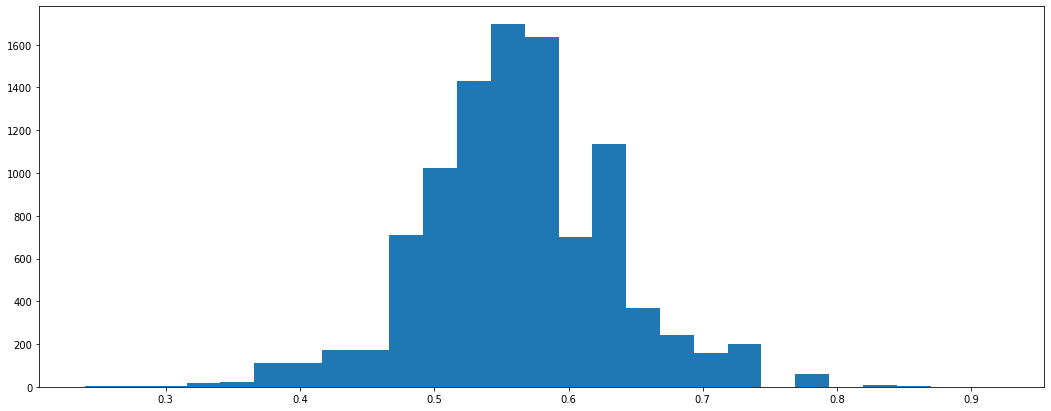

In [4]:
print('mean of all jaccard similarities: ', round(np.mean(lst_score), 2))
plt.figure(figsize=(18,7))
plt.hist(lst_score, bins=27);

### From above :
- There is similarity between doccuments
- The average document similarity is 0.56
- We calculated similary of first 2 documents and used its interection as new document to find similarity with forth document:
    - Its good way to link multiple documents
    - Downside: as we move to next document we loose some information each time hence the similarity set we have at first iteration might not have any relation with the last.

###  Analysis:
- Jaccard Similarity is based on the number of common attributes is divided by the number of attributes that exists in at least one of the two objects.
- From above data we can clearly see that Jaccard distance is good preliminary tool to measure similarity within docs.
- However for clustering it has one major disadvantage; small sets are never close to large sets.


### *We need to explore further*


## 2. TF-IDF:
#### TF-IDF stands for Term Frequency-Inverse Document Frequency
- Term frequency-Inverse document frequency uses all the tokens in the dataset as vocabulary. <br />
- Frequency of occurrence of a token from vocabulary in each document consists of the term frequency and number of documents in which token occurs determines the Inverse document frequency.<br />
- What this ensures is that,if a token occurs frequently in a document that token will have high TF but if that token occurs frequently in majority of documents then it reduces the IDF <br />
- stop words like an, the, i, as which occur frequently are penalized and important words which contain the essence of document get a boost. <br />
> `Term frequency–inverse document frequency`, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus."<br />
`Term Frequency`: is a scoring of the frequency of the word in the current document.<br />
`Inverse Document Frequency`: is a scoring of how rare the word is across documents.

In [5]:
# joining lemmatized words as sentences:
df_text['join_documents'] = df_text['lemmatized_description'].apply(lambda x: ' '.join(list(x)))
df_text.head(3)

,lemmatized_description,join_documents
0,"[dubai, group, lead, al, qaeda, ally, abu, musab, al, zarqawi, say, behead, two, iraqi, soldier, broad, daylight, mosul, statement, find, islamist, web, site, friday, say]",dubai group lead al qaeda ally abu musab al zarqawi say behead two iraqi soldier broad daylight mosul statement find islamist web site friday say
1,"[santa, monica, calif, star, video, game, industry, come, force, tuesday, night, honor, peer, creative, excellence, take, page, hollywood, playbook, red, carpet, glitter, gem, live, nationwide, broadcast]",santa monica calif star video game industry come force tuesday night honor peer creative excellence take page hollywood playbook red carpet glitter gem live nationwide broadcast
2,"[ap, week, rally, marche, nearly, arrest, leave, anti, bush, protester, drain, city, refute, allegation, demonstrator, hold, long, police, custody]",ap week rally marche nearly arrest leave anti bush protester drain city refute allegation demonstrator hold long police custody


### Vectorizer:
- TfidfVectorizer create numpy sparse matrix
- Matrix is sparse if many of its coefficients are zero 

In [6]:
vectorizer = TfidfVectorizer(max_df=.65, min_df=1, stop_words=None, use_idf=True)
transformed_documents = vectorizer.fit_transform(df_text['join_documents'])
transformed_documents

<9993x17221 sparse matrix of type '<class 'numpy.float64'>'
	with 189442 stored elements in Compressed Sparse Row format>

In [7]:
transformed_documents_as_array = transformed_documents.toarray()
# to verify that the numpy array represents the same number of documents that we have in the file list
len(transformed_documents_as_array)

9993

In [8]:
# loop each item in transformed_documents_as_array, using enumerate to keep track of the current position
# for counter, doc in enumerate(transformed_documents_as_array):
#     # construct a dataframe
#     tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
#     one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)

# one_doc_as_df

### To Find the Optimal Number of Clusters:
A good cluster is one with the distance between the points within the cluster must be less and the distance between the two centroids of two different clusters must be more.

We evaluate for the optimal number of clusters using two predominant methods:
- Elbow method
- Average Silhouette method


In [9]:
def optimal_k(min_val, max_val):
    Sum_of_squared_distances = []
    K = range(min_val, max_val)
    for k in K:
        kmeans_model = KMeans(n_clusters=k, init='k-means++', n_jobs=12)
        kmeans_model = kmeans_model.fit(transformed_documents_as_array)
        Sum_of_squared_distances.append(kmeans_model.inertia_)
    
    return Sum_of_squared_distances, K

In [10]:
def plot_k(K, Sum_of_squared_distances):
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xticks(list(range(0, 120, 8)))
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

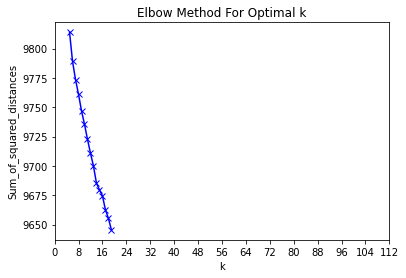

In [12]:
Sum_of_squared_distances, K = optimal_k(5, 20)
plot_k(K, Sum_of_squared_distances)

#### as we can see the training time is very high since we are dealing with sparse matrix generated by TF-IDF
- For initial analysis we are considering 20 as optimal cluster value

In [19]:
kmeans_model = KMeans(n_clusters=20, init='k-means++', algorithm='auto', max_iter=500, n_jobs=12) 
X = kmeans_model.fit(transformed_documents_as_array)

#### get the centroids and features

In [20]:
order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1]
order_centroids

array([[13429, 17096, 10413, ...,  3530, 15639,  9010],
       [ 5591, 16868, 13584, ..., 13599,  8346, 10771],
       [13571,  6049, 15252, ..., 15266, 10771,  7424],
       ...,
       [10771, 11941, 16107, ...,  2968, 10402,  9232],
       [11130,  6112,  7846, ...,  2671,  8590, 11387],
       [10805,   952, 14329, ..., 16649, 10771, 13296]], dtype=int64)

In [21]:
terms = vectorizer.get_feature_names()

#### Creating Clusters

In [22]:
df_clusters = pd.DataFrame()
for i in range(20):
    vals = []
    for ind in order_centroids[i, :20]:
        vals.append(terms[ind])
    df_clusters['Cluster_'+str(i+1)] = vals
df_clusters.head(20)

,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10,Cluster_11,Cluster_12,Cluster_13,Cluster_14,Cluster_15,Cluster_16,Cluster_17,Cluster_18,Cluster_19,Cluster_20
0,say,first,season,microsoft,quarter,oracle,fullquote,space,quot,nuclear,minister,state,president,kill,company,point,search,oil,palestinian,olympic
1,year,win,game,software,percent,peoplesoft,aspx,nasa,say,iran,prime,united,bush,people,service,score,google,price,gaza,athen
2,new,second,team,window,sale,takeover,quickinfo,spacecraft,we,korea,sharon,nation,election,say,inc,win,engine,unitedstate,israeli,sox
3,we,victory,league,corp,third,bid,ticker,moon,yesterday,weapon,ariel,say,presidential,iraq,say,victory,web,stock,arafat,medal
4,one,run,coach,linux,profit,hostile,href,station,game,uranium,say,secretary,kerry,baghdad,new,lead,inc,high,yasser,red
5,yesterday,cup,ap,xp,report,corp,http,launch,new,north,blair,manchester,john,iraqi,phone,rebound,yahoo,crude,israel,gold
6,make,champion,player,system,inc,billion,www,flight,call,enrichment,tony,tuesday,say,two,mobile,game,desktop,rise,leader,boston
7,report,sunday,last,company,rise,rival,stock,crew,would,say,foreign,unite,ap,bomb,music,night,internet,dollar,kill,game
8,ap,new,year,operating,earning,software,target,saturn,year,atomic,iraq,friday,vote,hostage,corp,second,new,we,militant,series
9,government,night,los,giant,say,inc,investor,international,iraq,program,israeli,we,george,police,computer,cup,microsoft,low,west,world


#### Classify the sentence which can tell us in which cluster the sentence belongs to:

In [38]:
print("Prediction")
document = 6777
print(df_text['join_documents'][document])
X = vectorizer.transform([df_text['join_documents'][document]])
print(X)
predicted = kmeans_model.predict(X)
print(f'predicted cluster: Cluster_{predicted[0]}')

Prediction
ap carl pavano probably return florida marlin need time choose among six american league team court
  (0, 15522)	0.1793474979509512
  (0, 15252)	0.18732933247596237
  (0, 14056)	0.22046572872915127
  (0, 12869)	0.2252629975479751
  (0, 11987)	0.28141839228032156
  (0, 11279)	0.3495192743225568
  (0, 10339)	0.22867914014018031
  (0, 9347)	0.32249556314952116
  (0, 8667)	0.20569679682108577
  (0, 5680)	0.25330627559417934
  (0, 3406)	0.22019953765293285
  (0, 2695)	0.288600000847982
  (0, 2359)	0.32546154747715506
  (0, 691)	0.1600101581367491
  (0, 542)	0.25627225992181324
  (0, 522)	0.20069651066475272
predicted cluster: Cluster_2


### From Above:
Some of the clusters are easy to infer and have good semantic relationship within words
- Cluster_1: Space/Science
- Cluster_2: Politics
- Cluster_3,Cluster_10, Cluster_16, Cluster_18: War
- Cluster_5, Cluster_9, Cluster_19: Sport
- Cluster_11, Cluster_20: Tech Industry
- Cluster_14: Oil/Trade
		
### Analysis:
- TF-IDF is very good measure for extracting features
- The Clusters generated using K-Mean clustering does make sense e.g cluster_1 can clearly tell us that its group words related to Space/Science
- **We can predict the topic based on words in cluster and use it as label**
- We are able to classify documents to its associated cluster

#### Downside:
- The Dimention of trainable metrix is very high since, TF-IDF create sparse metrix
- Algorithm like K-Mean process slower as we increase dimentions
- We can reduce dimentions using PCA, t-SNE, deep learning model like **Autoencoders**

## 3. Gensim doc2vec:
### Word2Vec:
> The Word2Vec Algorithm builds distributed semantic representation of words. <br />
> There are two main approaches to training:<br />
>- Distributed Bag of Words and <br />
>- The skip gram model.<br />
>
> One involves predicting the `context words` using a `centre word`, while the other involves predicting the `word` using the `context words`. <br />

### SentenceToVec:
> The same idea can be extended to sentences and complete documents where instead of learning feature representations for words, you learn it for sentences or documents. <br />
> However, to get a general idea of a SentenceToVec, think of it as a `mathematical average` of the `word vector` representations of all the words in the sentence. <br />
> We can get a very good approximation just by averaging and without training any SentenceToVec but of course, it has its limitations.

### Doc2Vec:
> Doc2Vec learns a randomly initialized vector for the document along with the words, (document could be a sentence).<br />
> Manually averaging word vectors doesnt perform to the same capacity because it fails to learn from the entire document.<br />
> Recently Paragram vectors have been extremely use while working with document similarity

#### Since we are dealing with multiple documents, Doc2Vec would be a better candidate to find similarities between multiple document:

In [42]:
# nltk.download('punkt')

### Setting Callback:
- Callback to print loss after each epoch 

In [43]:
class callback(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.epoch += 1

### Define Doc2Vec model:
- #### `dm(distributed memory) = 1`: 
    - Uses PV-DM algorithm to predicts 1 word from 4 (arbitary number) inputs.
    - PV-DM draw words from surround words of the target word.
    - Stores both both softmax weights and word vectors
    
    
#### *Since we dont have labeled data to automatically calculate the accuracy/effectiveness of our model, It doesn't make too much sense to split dataset for unsupervised learning*

In [66]:
def create_doc2vec(data):
    # Ceate taged data 
    tagged_data = [TaggedDocument(words = doc, tags=[i]) for i, doc in enumerate(data)]
    
    # Creating Doc2Vec model
    # commenting callbacks=[callback()] to preserve memory
    model_d2v = Doc2Vec(vector_size=300, alpha=0.025, dm=1, min_alpha=0.001, workers=12)
    
    # Building Doc2Vec Model
    model_d2v.build_vocab(tagged_data)
    
    # Training Doc2Vec Model  
    for epoch in range(100):
        if epoch%10 == 0 or epoch==99:
            print(f"Train model_d2v for epoch: {epoch}")
            
        model_d2v.train(tagged_data, total_examples = model_d2v.corpus_count, epochs = model_d2v.epochs)

    # Document embedding
    document_embeddings = np.zeros((data.shape[0],300))

    for i in range(len(document_embeddings)):
        document_embeddings[i] = model_d2v.docvecs[i]

    pairwise_similarities = cosine_similarity(document_embeddings)
    pairwise_differences = euclidean_distances(document_embeddings)
    
    model_d2v.save("model_d2v.model")
    pickle.dump(pairwise_similarities, open("pairwise_similarities.pkl", "wb"))
    pickle.dump(pairwise_differences, open("pairwise_differences.pkl", "wb"))
    
    return model_d2v, pairwise_similarities, pairwise_differences

### Training the model:
- Check if both the file present or not; 
- Calculating document_embeddingsis computationaly intensive but,
- Pairwise similarities are not hence we will train model if any of the pickled model absent 

In [67]:
def train_load_doc2vec(data):
    if os.path.isfile("model_d2v.model") and os.path.isfile("pairwise_similarities.pkl") and os.path.isfile("pairwise_differences.pkl"):
        try:
            print('Loading models from pickled data:')
            model_d2v = Doc2Vec.load("model_d2v.model")
            pairwise_similarities = pickle.load(open('pairwise_similarities.pkl', 'rb'))            
            pairwise_differences = pickle.load(open('pairwise_differences.pkl', 'rb'))
            print('Successfully loaded the models!')
        except Exception: 
            print('Error while reading files Training model again:')
            create_doc2vec(data)
            print('Model Trained and pickled!')
    else:
        print('File does not exist; Training model again:')
        model_d2v, pairwise_similarities, pairwise_differences = create_doc2vec(data)
        print('Model Trained and pickled!')
    return model_d2v, pairwise_similarities, pairwise_differences

In [68]:
model_d2v, pairwise_similarities, pairwise_differences = train_load_doc2vec(df_text['lemmatized_description'])

File does not exist; Training model again:
Train model_d2v for epoch: 0
Train model_d2v for epoch: 10
Train model_d2v for epoch: 20
Train model_d2v for epoch: 30
Train model_d2v for epoch: 40
Train model_d2v for epoch: 50
Train model_d2v for epoch: 60
Train model_d2v for epoch: 70
Train model_d2v for epoch: 80
Train model_d2v for epoch: 90
Train model_d2v for epoch: 99
Model Trained and pickled!


### Getting documents based on Cosine similarities and Ecludean Distance:

In [71]:
def most_similar(doc_id,similarity_matrix, matrix, sim_count):
    print (f'Document: {df_text.iloc[doc_id]["lemmatized_description"]}')
    print (f'\nTop {sim_count} Similar Documents:')
    if matrix == 'Cosine Similarity':
        similar_ix=np.argsort(similarity_matrix[doc_id])[::-1]
    elif matrix == 'Euclidean Distance':
        similar_ix=np.argsort(similarity_matrix[doc_id][::-1])
    i=0
    for ix in similar_ix:
        if ix == doc_id:
            continue
        print('\n')
        print (f'Document {i}: {df_text.iloc[ix]["lemmatized_description"]}')
        print (f'{matrix} : {similarity_matrix[doc_id][ix]}')
        if i == sim_count:
            break
        i += 1

### Calculating similarity between documents:
The function Most similar take:
- doc_id: document id,
- Type of similarity Cosine or Euclidean
- Top *`N`* similar documents

In [72]:
print('Cosine Similarity: ---------------------- ')
most_similar(1, pairwise_similarities, 'Cosine Similarity', 5)

Cosine Similarity: ---------------------- 
Document: ['santa', 'monica', 'calif', 'star', 'video', 'game', 'industry', 'come', 'force', 'tuesday', 'night', 'honor', 'peer', 'creative', 'excellence', 'take', 'page', 'hollywood', 'playbook', 'red', 'carpet', 'glitter', 'gem', 'live', 'nationwide', 'broadcast']

Top 5 Similar Documents:


Document 0: ['new', 'york', 'unitedstate', 'stock', 'advance', 'slightly', 'monday', 'investor', 'optimistic', 'corporate', 'earning', 'report', 'may', 'exceed', 'expectation', 'oil', 'fresh', 'record', 'near', 'barrel', 'curb', 'gain']
Cosine Similarity : 0.7617853565497203


Document 1: ['former', 'newspaper', 'baron', 'conrad', 'black', 'resign', 'chairman', 'chief', 'executive', 'hollinger', 'inc', 'tuesday', 'expect', 'move', 'design', 'help', 'take', 'canadian', 'hold', 'company', 'private']
Cosine Similarity : 0.7519483106163001


Document 2: ['advancedforce', 'ceo', 'vladimir', 'chernavsky', 'say', 'late', 'row', 'usb', 'port', 'part', 'big', 'de

In [73]:
print('Euclidean Distance: ----------------------')
most_similar(1, pairwise_differences, 'Euclidean Distance', 5)

Euclidean Distance: ----------------------
Document: ['santa', 'monica', 'calif', 'star', 'video', 'game', 'industry', 'come', 'force', 'tuesday', 'night', 'honor', 'peer', 'creative', 'excellence', 'take', 'page', 'hollywood', 'playbook', 'red', 'carpet', 'glitter', 'gem', 'live', 'nationwide', 'broadcast']

Top 5 Similar Documents:


Document 0: ['nebraska', 'capitalize', 'four', 'pittsburgh', 'turnover', 'bat', 'pass', 'end', 'zone', 'game', 'final', 'play', 'yesterday', 'preserve', 'win', 'first', 'meeting', 'team', 'since']
Euclidean Distance : 11.319887108544396


Document 1: ['voter', 'belarus', 'appear', 'approve', 'referendum', 'scrap', 'term', 'limit', 'allow', 'country', 'authoritarian', 'leader', 'seek', 'third', 'term', 'office']
Euclidean Distance : 10.535890530816596


Document 2: ['el', 'fashir', 'sudan', 'two', 'week', 'sudanese', 'authority', 'guerrilla', 'enemy', 'sign', 'pledge', 'restore', 'security', 'broaden', 'access', 'aid', 'group', 'fresh', 'surge', 'violence

### Compute vector for existing document

In [108]:
wordvec_ex = model_d2v.infer_vector([df_text['lemmatized_description'][5]])
ids = model_d2v.docvecs.most_similar(positive=[wordvec_ex], topn=5)
ids

[(160, 0.20112547278404236),
 (502, 0.18830378353595734),
 (1524, 0.18784043192863464),
 (6495, 0.18640771508216858),
 (8306, 0.1830066442489624)]

In [97]:
print('Target Document:\n', df_text['lemmatized_description'][5])
print('Predicted Similar document:\n', df_text['lemmatized_description'][160])

Target Document:
 ['un', 'ask', 'extra', 'force', 'police', 'storm', 'hit', 'gonaive', 'amid', 'breakdown', 'law', 'order', 'collapse']
Predicted Similar document:
 ['reuter', 'strong', 'earthquake', 'aftershock', 'strike', 'central', 'california', 'tuesday', 'rattle', 'large', 'chunk', 'state', 'along', 'san', 'andreas', 'fault', 'cause', 'little', 'significant', 'damage']


## Clustering the trained ebedding:
### K- Mean clustering:

#### Finding optimal value of K:
#### The Elbow Method:
> Calculate the Within-Cluster-Sum of Squared Errors (WSS) for different values of k, and choose the k for which WSS becomes first starts to diminish. <br />
> In the plot of WSS-versus-k, this is visible as an elbow.

In [46]:
def optimal_k(min_val, max_val):
    Sum_of_squared_distances = []
    K = range(min_val, max_val)
    for k in K:
        kmeans_model = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_jobs=12)
        kmeans_model = kmeans_model.fit(model_d2v.docvecs.doctag_syn0)
        Sum_of_squared_distances.append(kmeans_model.inertia_)
    
    return Sum_of_squared_distances, K

In [47]:
def plot_k(K, Sum_of_squared_distances):
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xticks(list(range(0, max(K), 8)))
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

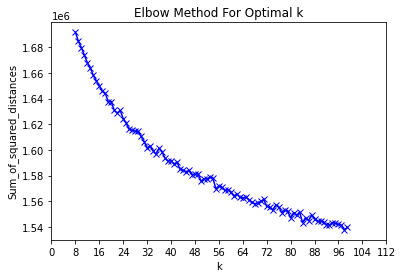

In [54]:
Sum_of_squared_distances, K = optimal_k(8, 100)
plot_k(K, Sum_of_squared_distances)

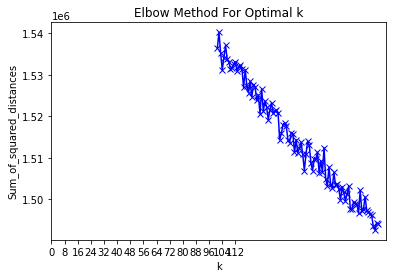

In [55]:
Sum_of_squared_distances, K = optimal_k(101, 200)
plot_k(K, Sum_of_squared_distances)

- It seems as we increase number of clusters the squared distance keep on decreasing which is good but having 1000+ cluster is not accurate representation  

#### The Silhouette Method:
> The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation).

In [60]:
def optimal_sil_k(min_val, max_val):
    sil = []
    K = range(min_val, max_val)
    # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
    for k in K:
        kmeans_model = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_jobs=12)
        kmeans_model = kmeans_model.fit(model_d2v.docvecs.doctag_syn0)
        labels = kmeans_model.labels_
        sil.append(silhouette_score(model_d2v.docvecs.doctag_syn0, labels, metric = 'euclidean'))
    return sil, K

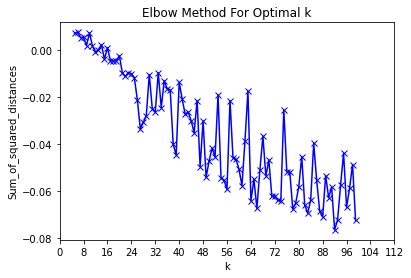

In [61]:
sil, K = optimal_sil_k(5, 100)
plot_k(K, sil)

#### From Silhouette Method:
We get the first peak at cluster value 16

#### Clustering:

In [98]:
kmeans_model = KMeans(n_clusters=16, init='k-means++', max_iter=3000, n_init=100, n_jobs=12) 
X = kmeans_model.fit(model_d2v.docvecs.doctag_syn0)
X

KMeans(max_iter=3000, n_clusters=16, n_init=100, n_jobs=12)

In [99]:
labels = kmeans_model.labels_.tolist()
l = kmeans_model.fit_predict(model_d2v.docvecs.doctag_syn0)
l

array([ 8, 13, 14, ..., 14,  1,  5])

#### get the centroids and features

In [102]:
order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1]
order_centroids

array([[191, 242, 217, ..., 276,   2,   1],
       [287,   7, 254, ..., 276, 188,  11],
       [  1, 288, 233, ..., 247, 276, 105],
       ...,
       [  1, 225, 191, ..., 114,  31, 222],
       [223, 191,  65, ..., 188, 295, 276],
       [  1,   8,  40, ...,  41, 222,  15]], dtype=int64)

In [103]:
terms = vectorizer.get_feature_names()

### Reducing Higher dimentional data using PCA: 

In [106]:
pca = PCA().fit(model_d2v.docvecs.doctag_syn0)
datapoint = pca.transform(model_d2v.docvecs.doctag_syn0)
datapoint

array([[-2.9034598e+00,  5.2359223e+00, -1.9486972e+00, ...,
        -1.2736544e-03, -2.0113587e-04,  8.7808445e-04],
       [ 3.7706757e+00, -4.1208208e-01, -2.1703520e-01, ...,
        -1.5143305e-05,  2.5944263e-03,  3.4254231e-03],
       [-4.8765573e-01, -7.1573156e-01, -1.6022313e+00, ...,
        -7.8853220e-04, -1.4250726e-04,  9.7431615e-04],
       ...,
       [-5.3528142e-01,  1.7139822e-01, -1.1526971e+00, ...,
         5.7364907e-04,  3.6895275e-05, -1.0530483e-03],
       [ 1.5962381e-02, -2.0927422e+00, -4.2643576e+00, ...,
        -1.5686676e-03, -2.4187565e-04,  1.2790374e-03],
       [ 2.5848842e+00,  6.3632030e+00,  2.3656268e+00, ...,
        -1.4927275e-03,  8.4555149e-04,  7.4935332e-04]], dtype=float32)

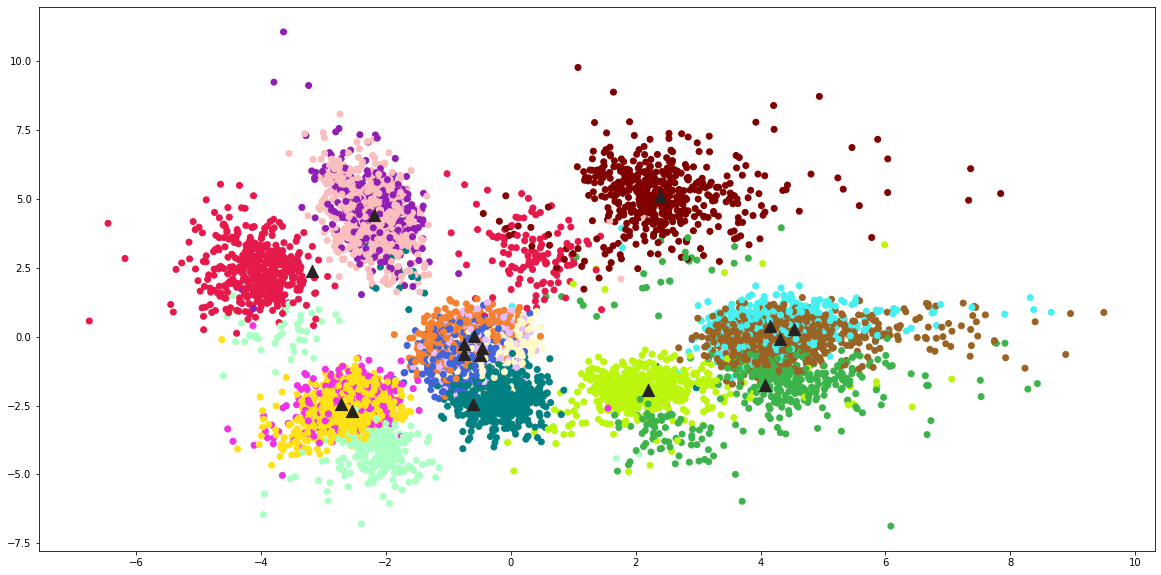

In [107]:
plt.figure(figsize=(20,10))
label1 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
color = [label1[i] for i in labels]

plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)

plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#262222')
plt.show()

### Analysis:
- from above we can see that there is similarity between documents
- Cosine similarity is good measure, since its value lies between `0 to 1` makes easy to compare
- Euclidean distance less intuitive, Since it gives absolute distance between the Doc2Vec vectors and we dont know the upper bound so difficult to compare

### *We can see there is similarities but we need to know in what way these documents are similar*:
    - We need to know the similarities based on semantic meaning like categories, groups, or clusters etc
    - LDA would be a better candidate
    
## Conclusion:
- **TF-IDF is good way to easure similarity within document**
- **There are clusters within documet.**
    - **`Cluster`: Group of documents which relate to similar meaning (semantically)**
    - **Here we are clustering documents based on there context similarity**
- **All documents are not about the same location**
- **Not all documents are similar but, some documents have similar based on topics like politics, sport, technology, war, crime, space etc**